In [1]:
#say no to warnings!
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
import tensorflow as tf
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from tensorflow.keras.backend import clear_session
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer,Dense

In [3]:
bc = datasets.load_breast_cancer()
x = bc.data
y = bc.target

In [4]:
xtrain, xtest, ytrain, ytest = \
    train_test_split(x, y, test_size = 0.25, stratify=y)

In [5]:
def get_model():
    model = Sequential()
    model.add(Dense(units=16, activation='relu', input_dim=30))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [6]:
%%time
clear_session()
model = get_model()
history = model.fit(xtrain, ytrain, epochs=5,
            validation_data=(xtest, ytest), verbose=0);

CPU times: user 1.38 s, sys: 876 ms, total: 2.26 s
Wall time: 1.94 s


### Callbacks!

In [11]:
[x for x in dir(tf.keras.callbacks.Callback())\
    if 'batch' in x]

['on_batch_begin',
 'on_batch_end',
 'on_predict_batch_begin',
 'on_predict_batch_end',
 'on_test_batch_begin',
 'on_test_batch_end',
 'on_train_batch_begin',
 'on_train_batch_end']

In [51]:
#un batch logger che salvi la loss ad ogni batch
class BatchLogger(tf.keras.callbacks.Callback):
    def on_train_begin(self,*args,**kwargs):
        self.batch_loss = []
    def on_batch_end(self,batch_num,logs):
        self.batch_loss+=[logs['loss']]

In [72]:
#un learning rate scheduler che setti il LR a 0.001 in epoche pari 
#e 0.005 in epoche dispari
class LRScheduler(tf.keras.callbacks.Callback):
    def on_epoch_begin(self,epoch,args,**kwargs):
        if epoch%2==0:#epoca pari
            self.model.optimizer.learning_rate = 0.001
        else:
            self.model.optimizer.learning_rate = 0.005

In [99]:
#un early stopper che fermi il training se validation accuracy > .9
class EarlyStopper(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs,**kwargs):
        if logs['val_accuracy']>.9:
            print('STOP AT EPOCH',epoch)
            self.model.stop_training=True

In [100]:
clear_session()
model = get_model()
batchlogger = BatchLogger()
lrscheduler = LRScheduler()
earlystopper = EarlyStopper()
history = model.fit(xtrain, ytrain, epochs=100,
            validation_data=(xtest, ytest), verbose=0,
            callbacks=[batchlogger,lrscheduler,earlystopper]);

STOP AT EPOCH 8


In [56]:
#batchlogger.batch_loss

In [107]:
stretched_epoch_loss = [[x]*14 for x in history.history['loss']]
flattened_epoch_loss = [a for b in stretched_epoch_loss for a in b]

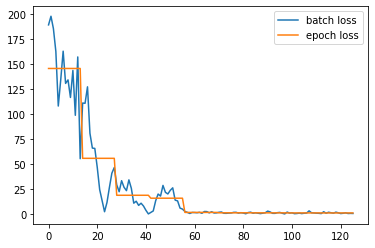

In [108]:
plt.plot(batchlogger.batch_loss,label='batch loss')
plt.plot(flattened_epoch_loss,label='epoch loss')
plt.legend();

In [117]:
for i in range(9):
    print('epoch',i)
    current_batch = batchlogger.batch_loss[14*i:14*(i+1)]
    batch_dimensions = [32]*13+[10]
    batch_mult = np.array(current_batch)*batch_dimensions
    print('avg batch loss',np.sum(batch_mult)/426)
    print('logged epoch loss',history.history['loss'][i])
    print()

epoch 0
avg batch loss 145.41090385902655
logged epoch loss 145.41090385902655

epoch 1
avg batch loss 55.58798891166006
logged epoch loss 55.58798891166006

epoch 2
avg batch loss 18.652804985896033
logged epoch loss 18.652804985896033

epoch 3
avg batch loss 15.719465425876384
logged epoch loss 15.719465425876384

epoch 4
avg batch loss 1.5056851447468074
logged epoch loss 1.5056851447468074

epoch 5
avg batch loss 1.1226318134388453
logged epoch loss 1.1226318134388453

epoch 6
avg batch loss 1.0704130004925276
logged epoch loss 1.0704130004925276

epoch 7
avg batch loss 1.004318488595631
logged epoch loss 1.004318488595631

epoch 8
avg batch loss 0.9795007950543237
logged epoch loss 0.9795007950543237



In [113]:
32*13+10

426